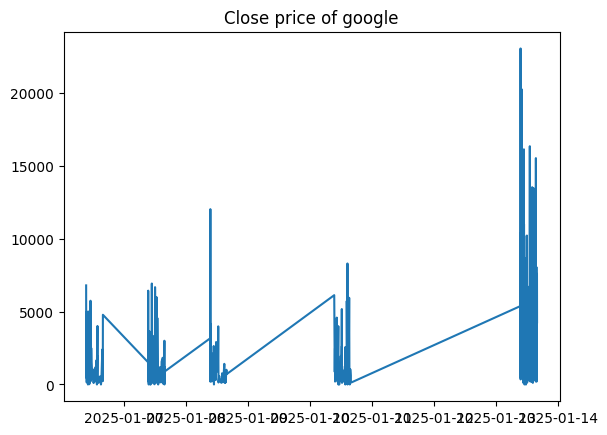

In [224]:
import yfinance as yf
import matplotlib.pyplot as plt

nvda = yf.Ticker("DJTWW")
data = nvda.history(period="5d", interval="1m")
data = data.dropna()
data=data.drop(["Dividends","Stock Splits"], axis=1)
plt.title("Close price of google")
plt.plot(data["Volume"])

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)
data = pd.DataFrame(data_normalized, columns=data.columns)




In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    674 non-null    float64
 1   High    674 non-null    float64
 2   Low     674 non-null    float64
 3   Close   674 non-null    float64
 4   Volume  674 non-null    float64
dtypes: float64(5)
memory usage: 26.5 KB


size of test dataset 2855


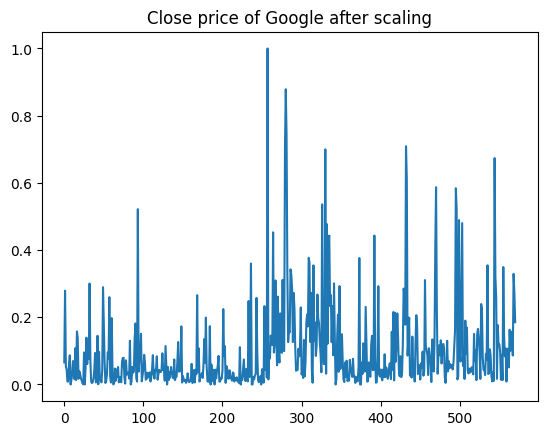

In [185]:
plt.title("Close price of Google after scaling")
plt.plot(data["Volume"])
data.head()
print("size of test dataset",data.size)

In [209]:
from stable_baselines3 import PPO

import gym

# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data):
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.account_balance =500
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1


        if self.current_step >= len(self.data):
            done = True
            self.current_step = 0  # Restart the episode
        else:
            done = False

        return self._next_observation(), self._get_reward(), done, {}

    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step].values[0]

        if action == 0:  # Buy

            if self.account_balance > current_price:
                self.shares_held += self.account_balance / current_price
                self.account_balance = 0  # Spend all the balance
        elif action == 1:  # Sell

            if self.shares_held > 0:
                self.account_balance += self.shares_held * current_price
                self.shares_held = 0  # Sell all shares



        self.net_worth = self.account_balance + self.shares_held * current_price


        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def _get_reward(self):

        return self.net_worth - (self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0])

env = TradingEnvironment(data)

In [210]:
from stable_baselines3 import DDPG, A2C, DQN
import numpy as np


model = DQN.load("model", env=env, verbose=1)
model.set_env(env)
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, env, num_episodes=10):
    total_rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)

    avg_total_reward = np.mean(total_rewards)
    print(f"Average total reward over {num_episodes} episodes: {avg_total_reward}")

    # Plot the rewards per episode
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_episodes + 1), total_rewards, marker='o', color='b', label="Total Reward per Episode")
    plt.axhline(y=avg_total_reward, color='r', linestyle='--', label=f'Average Reward: {avg_total_reward:.2f}')
    plt.title('Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Average total reward over 10 episodes: 157.6661278814908


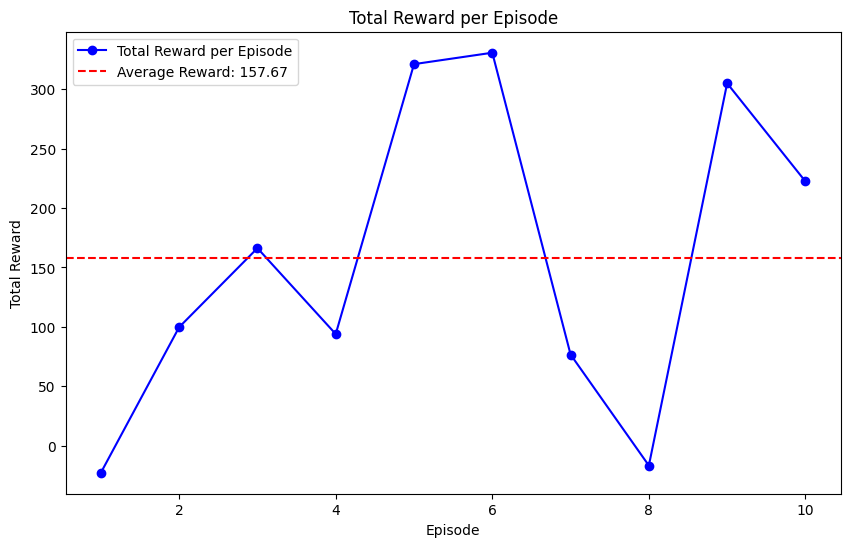

In [213]:
test_env = TradingEnvironment(data)
evaluate_model(model, test_env)

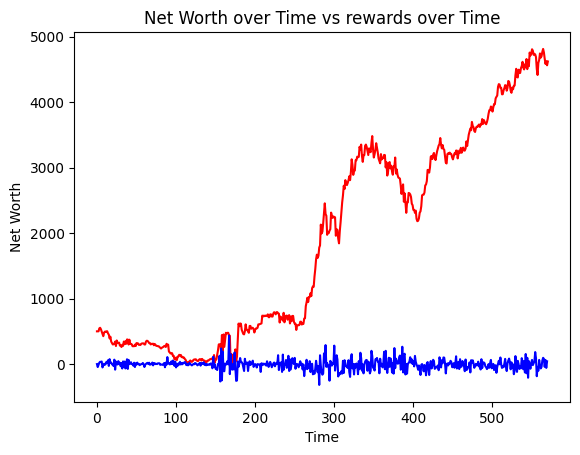

In [214]:
def simulate_trading_strategy(model, data):
    env = TradingEnvironment(data)
    obs = env.reset()


    net_worth_history = [env.net_worth]
    reward_history = []

    for _ in range(len(data) - 1):  # Adjust loop to avoid exceeding data length
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)

        # Append the current net worth and reward to their respective histories
        net_worth_history.append(env.net_worth)
        reward_history.append(reward)

        # Check if done flag is reached
        if done:
            print("Reached the end of the dataset.")
            break

    return net_worth_history, reward_history
net_worth,reward_history = simulate_trading_strategy(model, data)
import matplotlib.pyplot as plt


# Plot the net worth over time
plt.plot(net_worth,color='red')
plt.plot(reward_history,color='blue')

plt.xlabel("Time")
plt.ylabel("Net Worth")
plt.title("Net Worth over Time vs rewards over Time")
plt.show()

570
-7.152117713003207


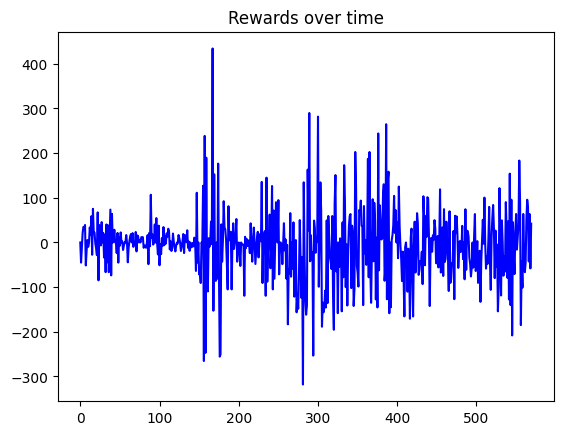

In [215]:
plt.plot(reward_history,color='blue')
plt.title("Rewards over time")
print(len(reward_history))
print(np.mean(reward_history))